# IST 652 Final Project - A Pantheon Exploration

# Introduction

Recorded human history has only been around for 5000 years. By understanding the makeup of Pantheon, all persons today both young and old are enriched with the knowledge of global, scientific and cultural development of humanity. The meaning of the word *Pantheon* describes a group of particularly respected, famous, or important people. Over the course of human history there have been thousands of such individuals that have made an impact on society. Due to the information age that began in the latter part of the 20th century, people all over the world now have access to the same biographies of these individuals through Wikipedia in multiple languages. What was once information of limited accessibility and supply, shelved in remote libraries, is now conveniently made available through this medium.

Credit goes to the Macro Connections group at the Massachusetts Institute of Technology Media Lab and their [Pantheon Project](https://www.kaggle.com/mit/pantheon-project). Not only was a Pantheon index made available to the general public, but a popularity index was created as well. One "barrier to entry" to this content is the number of languages available for each article. This is a key measure in determining the popularity of individuals in the Pantheon. "The simpler of the two measures, which we denote as L, is the number of different Wikipedia language editions that have an article about a historical character. The more sophisticated measure, which we name the Historical Popularity Index (HPI) corrects L by adding information on the age of the historical character, the concentration of page views among different languages, the coefficient of variation in page views, and the number of page views in languages other than English." [https://www.kaggle.com/mit/pantheon-project](https://www.kaggle.com/mit/pantheon-project)

The significance of historical figures may be debatable, but this report seeks to apply an objective measure of popularity to better understand how biographies of the Pantheon is being consumed in the current day and age. From Aristotle to Benjamin Franklin, Jesus Christ to Al Pacino, historical figures and their attributes will be measured with web analytics so that the reader may have insights into the following:

Research questions:

* Which historic characters are the most popular?
* When did they live and where are they from?
* What factors could have generated their popularity?
* Are there any observable trends in the categorical data provided?
* What clusters and groupings are in the data? How do groups compare in popularity?

# Analysis

Key analysis methods used in report:
* Data Cleaning
* Sorting and subsets of the data.
* Line and bar plots.
* Multiple regression

In [141]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn

## About the Data

In [142]:
dataFileName = "data/database.csv"
isExist = os.path.isfile(dataFileName)
if isExist == True:
    dfDirtyData = pd.read_csv(dataFileName, sep=",", header=0)
else:
    print("File not found:", os.getcwd())


A variable called dataFileName is create to store the data file name. Then the dataFileName is checked to make it exists in the current working directory. The boolean value then stored in isExist variable. If the value of the isExist is true then the file is loaded into a Pandas dataframe otherwise a message is printed to remind that the file does exists or miss-spelled.

In [143]:
dfDirtyData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11341 entries, 0 to 11340
Data columns (total 17 columns):
article_id                     11341 non-null int64
full_name                      11341 non-null object
sex                            11341 non-null object
birth_year                     11341 non-null object
city                           11341 non-null object
state                          2172 non-null object
country                        11308 non-null object
continent                      11311 non-null object
latitude                       10294 non-null float64
longitude                      10294 non-null float64
occupation                     11341 non-null object
industry                       11341 non-null object
domain                         11341 non-null object
article_languages              11341 non-null int64
page_views                     11341 non-null int64
average_views                  11341 non-null int64
historical_popularity_index    11341 non-null 

The .info() function is used to display the information about the dataframe. This function provides the dataframe information such as column names, total count of rows for each column, and data types. 

In [144]:
columnToDisplayDirtyData = ['full_name', 'sex', 'birth_year', 'country', 'occupation','historical_popularity_index']

There too many columns in the dataset that would not fit nicely on the report. A variable called columnToDisplayDirtyData is created to store customized number of columns to display. There are six columns included: full_name', 'sex', 'birth_year', 'country', 'occupation', and 'historical_popularity_index'

In [145]:
# Section 4
dfDirtyData.loc[1522]

article_id                             23671899
full_name                                Elisha
sex                                        Male
birth_year                              Unknown
city                                      Other
state                                       NaN
country                                 Unknown
continent                               Unknown
latitude                                    NaN
longitude                                   NaN
occupation                     Religious Figure
industry                               Religion
domain                             Institutions
article_languages                            41
page_views                              1338790
average_views                             32653
historical_popularity_index             25.5087
Name: 1522, dtype: object

The .loc() function is used to locate a row data based the row index to display on the report.


In [146]:
dfDirtyData.loc[:,columnToDisplayDirtyData].head(5)

,full_name,sex,birth_year,country,occupation,historical_popularity_index
0,Aristotle,Male,-384,Greece,Philosopher,31.9938
1,Plato,Male,-427,Greece,Philosopher,31.9888
2,Jesus Christ,Male,-4,Israel,Religious Figure,31.8981
3,Socrates,Male,-469,Greece,Philosopher,31.6521
4,Alexander the Great,Male,-356,Greece,Military Personnel,31.5840


The .head(5) function is used to display the first 5 rows in the dataset. The columns to display are based on the variable  called columnToDisplayDirtyData that was created in Section 3.

In [147]:
dfDirtyData.loc[:,columnToDisplayDirtyData].tail(5)

,full_name,sex,birth_year,country,occupation,historical_popularity_index
11336,Sean St Ledger,Male,1984,United Kingdom,Soccer Player,11.1346
11337,Saina Nehwal,Female,1990,India,Athlete,10.6122
11338,Rūta Meilutytė,Female,1997,Lithuania,Swimmer,10.3821
11339,Vladimír Weiss,Male,1989,Slovakia,Soccer Player,10.2495
11340,Missy Franklin,Female,1995,United States,Swimmer,9.8794


The .tail(5) function is used to display the last 5 rows in the dataset. The columns to display are based on the variable  called columnToDisplayDirtyData that was created in Section 3.

## Data Cleaning
#### There are data issues so there are a few functions were create to help automate the cleaning process.

In [148]:
def fillNaN(df, dataType, defaultValue):
    for column in df.columns:
        if(df[column].dtype == dataType):
            df[column].fillna(value = defaultValue, inplace=True)

fillNaN() function takes three input paramters: data frame, data Type, and default value. This function is designed to replace the NaN value with the default value provided by the caller based on a matching data type. Below are examples on how the function can be called:
* fillNaN(dfCleanData,'object', 'Unknown')
* fillNaN(dfCleanData,'float64', 12345.888)

In [149]:
def removeCharFromNumber(inputValue):
    a = ''
    inputValue = str(inputValue)
    for char in inputValue:
        if char.isdigit() == True:
            a = a + char
    return a

removeCharFromNumber() function takes one inpurt parameter: string or text. This function iterates through, finds, and concatenates numbers together. Below are examples on how the function can be called:
* removeCharFromNumber('127?')

In [150]:
def convertToNumber(df, columns):
    for col in columns:
        for idx, value in enumerate(df[col]):
            try:
                int(value)
            except:
                newValue = ''
                newValue = removeCharFromNumber(value)
                if newValue != '':
                    df.loc[idx, col] = newValue
                else:
                    df.loc[idx, col] = 0

convertToNumber() function takes two input parameters: a dataframe and a list of column names. This function is designed to convert the values for each column from possible alpha-numeric to numeric and default the value to zero if nothing is there.

Example:
* columnList = [['birth_year', 'latitude', 'longitude']]
* convertToNumber(dataframe, columnList)

In [151]:
dfCleanData = dfDirtyData.copy()

The .copy() function is used to make a copy of the original dataframe into a new one. This way when the modification is made to the new dataframe, data in the original dataframe will not be touched.

In [152]:
dfCleanData.rename(columns={'historical_popularity_index': 'popularity'}, inplace=True)

'historical_popularity_index' column is being rename as 'popularity' so it fits much nicely for displaying purposes.

In [153]:
fillNaN(dfCleanData, 'object', 'Unknown')

fillNaN() function is called by passing a dataframe (dfCleanData), data type ('object'), and default value ('Unknown). The funtion then go through the dataframe, looking for columns with 'object' data type then replace 'na' with 'Unknown'

In [155]:
columnToNumeric = ["article_languages", "birth_year", "latitude", "longitude", "page_views","average_views", "popularity"]
convertToNumber(dfCleanData, columnToNumeric)
dfCleanData[columnToNumeric] = dfCleanData[columnToNumeric].apply(pd.to_numeric)
#for col in columnToNumeric:
#    indx = []
#    indx = findStringValueIndex(dfCleanData, col)
#    if len(indx) > 0 :
#        dfCleanData.loc[indx, col] = 0
# Converting the columns above to numeric data type

In [156]:
# List of columns to be converted into numeric data type
#columnToConvert = ["birth_year"]
# Making sure to replace the non-numeric values to 0 before converting to numeric
# Examples: 
#           dfCleanData.loc[findStringValueIndex('latitude'), 'latitude'] = 0
# The following code block is doing similiar to the examples but 
# through the iteration of the list 
# replaced incorrect birth year with an actual year
#dfCleanData['birth_year'] = dfCleanData['birth_year'].replace(['1237?'], 1237).replace(['530s'], 530)

In [157]:
# Showing inforamtion about the dataframe
dfCleanData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11341 entries, 0 to 11340
Data columns (total 17 columns):
article_id           11341 non-null int64
full_name            11341 non-null object
sex                  11341 non-null object
birth_year           11341 non-null int64
city                 11341 non-null object
state                11341 non-null object
country              11341 non-null object
continent            11341 non-null object
latitude             11341 non-null float64
longitude            11341 non-null float64
occupation           11341 non-null object
industry             11341 non-null object
domain               11341 non-null object
article_languages    11341 non-null int64
page_views           11341 non-null int64
average_views        11341 non-null int64
popularity           11341 non-null float64
dtypes: float64(3), int64(5), object(9)
memory usage: 1.5+ MB


In [158]:
print('Dirty Data:', dfDirtyData[dfDirtyData['birth_year'] == '1237?'].loc[:,'birth_year'])
print()
print('Clean Data:', dfCleanData[dfCleanData['birth_year'] == 1237].loc[:,'birth_year'])


Dirty Data: 3009    1237?
Name: birth_year, dtype: object

Clean Data: 3009    1237
Name: birth_year, dtype: int64


In [159]:
print('Dirty Data:', dfDirtyData[dfDirtyData['article_id'] == 23671899].loc[:,'birth_year'])
print()
print('Clean Data:', dfCleanData[dfCleanData['article_id'] == 23671899].loc[:,'birth_year'])

Dirty Data: 1522    Unknown
Name: birth_year, dtype: object

Clean Data: 1522    0
Name: birth_year, dtype: int64


In [160]:
print('Dirty Data:', dfDirtyData[dfDirtyData['article_id'] == 23671899].loc[:,'state'])
print()
print('Clean Data:', dfCleanData[dfCleanData['article_id'] == 23671899].loc[:,'state'])

Dirty Data: 1522    NaN
Name: state, dtype: object

Clean Data: 1522    Unknown
Name: state, dtype: object


In [161]:
# Creating a varibale to hold fields for displaying purpose since not all will fit
columnToDisplayCleanData = ['full_name', 'sex', 'birth_year', 'country', 'industry','domain','occupation','popularity']

In [162]:
# Showing the first 5 rows of the data in the dataset
dfCleanData.loc[:,columnToDisplayCleanData].head(5)

,full_name,sex,birth_year,country,industry,domain,occupation,popularity
0,Aristotle,Male,-384,Greece,Philosophy,Humanities,Philosopher,31.9938
1,Plato,Male,-427,Greece,Philosophy,Humanities,Philosopher,31.9888
2,Jesus Christ,Male,-4,Israel,Religion,Institutions,Religious Figure,31.8981
3,Socrates,Male,-469,Greece,Philosophy,Humanities,Philosopher,31.6521
4,Alexander the Great,Male,-356,Greece,Military,Institutions,Military Personnel,31.5840


In [163]:
# Showing the last 5 rows of the data in the dataset
dfCleanData.loc[:,columnToDisplayCleanData].tail(5)

,full_name,sex,birth_year,country,industry,domain,occupation,popularity
11336,Sean St Ledger,Male,1984,United Kingdom,Team Sports,Sports,Soccer Player,11.1346
11337,Saina Nehwal,Female,1990,India,Individual Sports,Sports,Athlete,10.6122
11338,Rūta Meilutytė,Female,1997,Lithuania,Individual Sports,Sports,Swimmer,10.3821
11339,Vladimír Weiss,Male,1989,Slovakia,Team Sports,Sports,Soccer Player,10.2495
11340,Missy Franklin,Female,1995,United States,Individual Sports,Sports,Swimmer,9.8794


In [164]:
#sn.heatmap()

## Exploration

In [165]:
# Grouping total by continent and sex
dfTotalByContinentBySex = pd.DataFrame(dfCleanData.groupby(['industry','sex'])['article_id'].count())
dfTotalByContinentBySex .rename(columns={'article_id': 'total_count'}, inplace=True)
dfTotalByContinentBySex.sort_values(by = ['industry'], ascending = True).head(10)

total_count
industry         sex                
Activism         Female           38
                 Male             76
Business         Female            4
                 Male             87
Companions       Female           94
                 Male              7
Computer Science Female            1
                 Male             32
Dance            Female            7
                 Male              5

TypeError: unhashable type: 'numpy.ndarray'

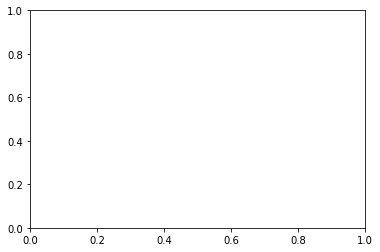

In [199]:
#x=[]
##y=[]
#x = dfByIndustry.loc[:, ['sex']]
#y = dfByIndustry.loc[:, ['birth_year']]
#width = 1
#plt.bar(x,y, width, lable="Sex and Birth Year")

In [176]:
#'Activism' 'Business' 'Computer Science' 'Dance' 'Design' 'Engineering' 'Explorers' 'Film And Theatre' 'Fine Arts'
#'Government' 'History' 'Individual Sports' 'Invention' 'Language' 'Law' 'Math' 'Media Personality' 'Medicine'
#'Military' 'Music' 'Natural Sciences' 'Outlaws' 'Philosophy' 'Religion' 'Social Sciences' 'Team Sports'
industry = 'Companions'
dfByIndustry = dfCleanData[dfCleanData['industry'] == industry].loc[:,columnToDisplayCleanData].sort_values(by = ['birth_year'], ascending = False)
dfByIndustry.head(10)

,full_name,sex,birth_year,country,industry,domain,occupation,popularity
9957,"Catherine, Duchess of Cambridge",Female,1982,United Kingdom,Companions,Public Figure,Companion,17.6612
10161,Kevin Federline,Male,1978,United States,Companions,Public Figure,Companion,17.1996
9647,"Mary, Crown Princess of Denmark",Female,1972,Australia,Companions,Public Figure,Companion,18.2924
8265,Vanessa Paradis,Female,1972,France,Companions,Public Figure,Companion,20.7830
9771,Princess Máxima of the Netherlands,Female,1971,Argentina,Companions,Public Figure,Companion,18.0350
9092,Queen Rania of Jordan,Female,1970,Kuwait,Companions,Public Figure,Companion,19.3986
9735,"Sophie, The Countess of Wessex",Female,1965,United Kingdom,Companions,Public Figure,Companion,18.1110
8368,Michelle Obama,Female,1964,United States,Companions,Public Figure,Companion,20.6330
6635,Laura Bush,Female,1946,United States,Companions,Public Figure,Companion,22.4461
5361,Priscilla Presley,Female,1945,United States,Companions,Public Figure,Companion,23.1960


In [167]:
# Getting the count by country, occupation, industry, and domain
dfTotalByCountryByIndustry = pd.DataFrame(dfCleanData.groupby(['industry','occupation'])['article_id'].count())
# Renaming the default column name the dataframe created to a meaningfull name
dfTotalByCountryByIndustry.rename(columns={'article_id': 'total_count'}, inplace=True)
dfTotalByCountryByIndustry.sort_values(by = ['total_count'], ascending = False).head(20)

total_count
industry          occupation                     
Government        Politician                 2530
Film And Theatre  Actor                      1193
Team Sports       Soccer Player              1064
Language          Writer                      954
Religion          Religious Figure            518
Music             Singer                      437
                  Musician                    381
Philosophy        Philosopher                 281
Natural Sciences  Physicist                   268
Music             Composer                    225
Military          Military Personnel          224
Natural Sciences  Chemist                     220
Fine Arts         Painter                     178
Film And Theatre  Film Director               177
Individual Sports Tennis Player               161
Math              Mathematician               157
Medicine          Physician                   142
Natural Sciences  Biologist                   141
Government        Nobleman                    116
Activism          Social Activist             114

In [168]:
# Which historic characters are in the top ten most popular?
dfTopTenMostPopularPeople = dfCleanData.sort_values(by = ['popularity'], ascending = False)
dfTopTenMostPopularPeople = dfTopTenMostPopularPeople.head(10)
dfTopTenMostPopularPeople.loc[:,columnToDisplayCleanData]

,full_name,sex,birth_year,country,industry,domain,occupation,popularity
0,Aristotle,Male,-384,Greece,Philosophy,Humanities,Philosopher,31.9938
1,Plato,Male,-427,Greece,Philosophy,Humanities,Philosopher,31.9888
2,Jesus Christ,Male,-4,Israel,Religion,Institutions,Religious Figure,31.8981
3,Socrates,Male,-469,Greece,Philosophy,Humanities,Philosopher,31.6521
4,Alexander the Great,Male,-356,Greece,Military,Institutions,Military Personnel,31.5840
5,Leonardo da Vinci,Male,1452,Italy,Invention,Science & Technology,Inventor,31.4644
6,Confucius,Male,-551,China,Philosophy,Humanities,Philosopher,31.3705
7,Julius Caesar,Male,-100,Italy,Government,Institutions,Politician,31.1161
8,Homer,Male,-800,Turkey,Language,Humanities,Writer,31.1087
9,Pythagoras,Male,-570,Greece,Philosophy,Humanities,Philosopher,31.0691


### Explaning the code
* jfdslajfasljfsd
### Which historic characters are the most popular?
* Aristotle, Plato, and Jesus Christ

In [169]:
dfTotalTop10ByCountry = pd.DataFrame(dfTopTenMostPopularPeople.groupby(['country'])['article_id'].count())
dfTotalTop10ByCountry.rename(columns={'':'country','article_id': 'total_count'}, inplace=True)
dfTotalTop10ByCountry 

,total_count
country,
China,1
Greece,5
Israel,1
Italy,2
Turkey,1


In [170]:
# Change to bar... use the dfCleanData
#plt.bar(dfTotalTop10ByCountry)

In [171]:
# Which historic characters are in the top ten least popular?
dfTopTenLeastPopularPeople = dfCleanData.sort_values(by = ['popularity'], ascending = True)
dfTopTenLeastPopularPeople = dfTopTenLeastPopularPeople.head(10)
dfTopTenLeastPopularPeople.loc[:,columnToDisplayCleanData].head(10)

,full_name,sex,birth_year,country,industry,domain,occupation,popularity
11340,Missy Franklin,Female,1995,United States,Individual Sports,Sports,Swimmer,9.8794
11339,Vladimír Weiss,Male,1989,Slovakia,Team Sports,Sports,Soccer Player,10.2495
11338,Rūta Meilutytė,Female,1997,Lithuania,Individual Sports,Sports,Swimmer,10.3821
11337,Saina Nehwal,Female,1990,India,Individual Sports,Sports,Athlete,10.6122
11336,Sean St Ledger,Male,1984,United Kingdom,Team Sports,Sports,Soccer Player,11.1346
11335,Jetro Willems,Male,1994,Netherlands,Team Sports,Sports,Soccer Player,11.3956
11334,Rebecca Soni,Female,1987,United States,Individual Sports,Sports,Swimmer,11.4050
11333,Sun Yang,Male,1991,China,Individual Sports,Sports,Swimmer,11.6234
11332,Shane Long,Male,1987,Ireland,Team Sports,Sports,Soccer Player,11.7174
11331,Marc Albrighton,Male,1989,United Kingdom,Team Sports,Sports,Soccer Player,11.7258


In [172]:
dfTotalTop10LByContinentByCountry = pd.DataFrame(dfTopTenLeastPopularPeople.groupby([ 'country','sex'])['article_id'].count())
dfTotalTop10LByContinentByCountry.rename(columns={'article_id': 'total_count'}, inplace=True)
dfTotalTop10LByContinentByCountry

,,total_count
country,sex,
China,Male,1
India,Female,1
Ireland,Male,1
Lithuania,Female,1
Netherlands,Male,1
Slovakia,Male,1
United Kingdom,Male,2
United States,Female,2


In [173]:
# Getting the count by countinent and by country
dfTotalByContinentByCountry = pd.DataFrame(dfCleanData.groupby(['continent', 'country'])['article_id'].count())
# Renaming the default column name the dataframe created to a meaningfull name
dfTotalByContinentByCountry.rename(columns={'article_id': 'total_count'}, inplace=True)
dfTotalByContinentByCountry.sort_values(by = ['total_count'], ascending = False).head(10)

total_count
continent     country                    
North America United States          2168
Europe        United Kingdom         1145
              France                  866
              Italy                   808
              Germany                 747
Unknown       Unknown                 438
Europe        Russia                  374
              Spain                   296
Asia          Turkey                  202
Europe        Poland                  173

In [174]:
# Getting the count by countinent
dfTotalByContinent = pd.DataFrame(dfCleanData.groupby(['continent'])['article_id'].count())
# Renaming the default column name the dataframe created to a meaningfull name
dfTotalByContinent.rename(columns={'article_id': 'total_count'}, inplace=True)
dfTotalByContinent.sort_values(by = ['total_count'], ascending = False)

,total_count
continent,
Europe,6368
North America,2439
Asia,1188
Unknown,438
Africa,419
South America,366
Oceania,123


## Modeling

# Results

# Conclusion